# Optimal Control of a Unicycle with Pyomo


In [2]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy as cp

# This cell is commented out because Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

 # install required dependencies
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:
#    !pip install -q pyomo
#    !apt-get install -y -qq glpk-utils
#    !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
#    !unzip -o -q ipopt-linux64


# Problem Statement

Consider a simple three-state model of a unicycle 


---



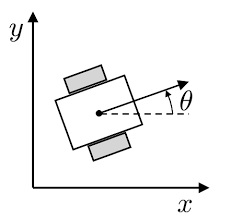



---





\begin{equation}
\begin{split}
 {\dot x} =& \sin(\theta) v\\
{\dot y} =& \cos(\theta) v\\
{\dot {\theta}} =&  \omega
\end{split}
\end{equation}

whre the conrol inputs are $u=[v,\omega]$ and thw state is the unicycle pose
$z=[x,y,\theta]$.
The control objective is to bring the unicle from an initial pose to a given termimal pose $z_f$ at time $T$  under some input constraints.

\begin{align}
\mid v \mid &< 1 m/s\\
\mid \omega \mid &< 1 rad/s \\
\end{align}

# Euler Discretization
Assume the sampling time is $T_s$. With Euler discretization, the model is 
\begin{equation}
z(k+1) = z(k) +T_sf(z(k),u(k))
\end{equation}
where 
\begin{equation}
\begin{split}
f_1(z,u) = & cos(z_3)u_1\\
f_2(z,u) = & sin(z_3)u_1\\
f_3(z,u) = & u_2\\
\end{split}
\end{equation}


In [3]:
# simulation parameters
Ts = 0.05
N = 50
TFinal = Ts*N
nx = 3

# x is state vector, u is input, Ts is sampling period, gamma and tau are parameters   
def fdis(x, u ,Ts,nx):
    z_next = np.empty((nx,))
    z_next[0] = z[0] + Ts*(np.cos(z[2]) *u[0])
    z_next[1] = z[1] + Ts*(np.sin(z[2]) *u[0])
    z_next[2] = z[2] + Ts*u[1]
    return z_next

# Finite Constrained Optimization Problem
we would like to solve the following FTCOC problem
\begin{align}
\min_{z_0,\ldots,z_N,u_0,\ldots,u_{N-1}} & \sum_{k=0}^{N-1} \|v_k \|_2^2 \nonumber\\
& z_{k+1} = z_k+f(z_k,u_k)\Delta t &&~\forall k = \left\{0,\ldots,N-1 \right\} \nonumber\\
& z_{min} \leq z_k \leq z_{max} &&~\forall k = \left\{0,\ldots,N \right\} \nonumber\\
& u_{min} \leq u_k \leq u_{max} &&~\forall k = \left\{0,\ldots,N-1 \right\} \nonumber\\
& z_0 = \bar{z}_0\nonumber\nonumber\\
& z_N = \bar{z}_N\nonumber
\end{align}

Now we formulate the CFTOC problem with Pyomo

In [4]:
# Finite constrained optimiation problem
import matplotlib.pyplot as plt
import numpy as np
import pyomo.environ as pyo

nx = 3         # number of states
nu = 2         # number of inputs

model = pyo.ConcreteModel()
model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
model.xidx = pyo.Set(initialize=range(0, nx))
model.uidx = pyo.Set(initialize=range(0, nu))

# Create state and input variables trajectory:
model.z = pyo.Var(model.xidx, model.tidx)
model.u = pyo.Var(model.uidx, model.tidx)

# Objective:
model.cost = pyo.Objective(expr = sum((model.u[0, t])**2 for t in model.tidx if t < N), sense=pyo.minimize)
# cost can be different, it is the job of the designer -> play with it 

# Constraints:
udotlim = 0.03
z0=[0,0,0]
zf=[1,1,np.pi/4]

model.constraint1 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[i, 0] == z0[i])
model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[0, t+1] == model.z[0, t] + Ts* (pyo.cos(model.z[2, t]) *model.u[0, t])
                                   if t < N else pyo.Constraint.Skip)
model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[1, t+1] == model.z[1, t] + Ts* (pyo.sin(model.z[2, t]) *model.u[0, t])
                                   if t < N else pyo.Constraint.Skip)
model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.z[2, t+1] == model.z[2, t] + Ts* model.u[1, t]
                                   if t < N else pyo.Constraint.Skip)
model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] <= 1 
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[0, t] >= -1 
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint7 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] <= 1 
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint8 = pyo.Constraint(model.tidx, rule=lambda model, t: model.u[1, t] >= -1 
                                   if t < N-1 else pyo.Constraint.Skip)
model.constraint9 = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[i, N] == zf[i])

# Now we can solve:
results = pyo.SolverFactory('ipopt').solve(model).write()
# SolverFactory('ipopt', executable='/content/ipopt').solve(model).write()
# model.display()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 352
  Number of variables: 253
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.5.5\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.10059142112731934
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


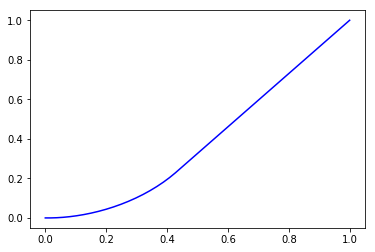

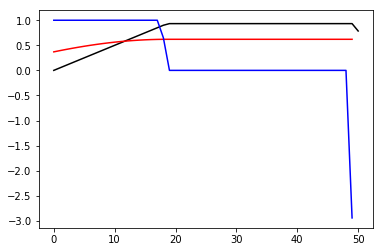

In [5]:
# plot results
z1 = [pyo.value(model.z[0,0])]
z2 = [pyo.value(model.z[1,0])]
z3 = [pyo.value(model.z[2,0])]
u1 = [pyo.value(model.u[0,0])]
u2 = [pyo.value(model.u[1,0])]

for t in model.tidx:
    if t < N:
        z1.append(pyo.value(model.z[0,t+1]))
        z2.append(pyo.value(model.z[1,t+1]))
        z3.append(pyo.value(model.z[2,t+1]))
    if t < N-1:
        u1.append(pyo.value(model.u[0,t+1]))
        u2.append(pyo.value(model.u[1,t+1]))
plt.figure(1)
plt.plot(z1, z2,'b')
plt.figure(2)
plt.plot( z3,'k')
plt.plot(u1,'r')
plt.plot(u2,'b')
plt.show()

## Solving the Continuous Time version

# Finite Constrained Optimization Problem
we would like to solve the following FTCOC problem in continous time
\begin{align}
\min_{z[0,T_f],u[0,T_f]} & \int_{0}^{T_f} \|v(t) \|_2^2 \nonumber\\
& \dot{z}(t) = f(z(t),u(t)) &&~\forall t \in [0,T_f] \nonumber\\
& u_{min} \leq u(t) \leq u_{max} &&~\forall t \in [0,T_f] \nonumber\\
& z(0) = \bar{z}_0\nonumber\nonumber\\
& z(T_f) = \bar{z}_N\nonumber
\end{align}

<function matplotlib.pyplot.show(*args, **kw)>

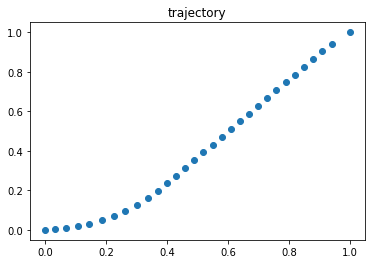

In [6]:
from pyomo.environ import *
from pyomo.dae import *


model = m = ConcreteModel()
m.tf = Param(initialize = TFinal)
m.t = ContinuousSet(bounds=(0, m.tf))
m.u1 = Var(m.t, initialize=0)
m.u2 = Var(m.t, initialize=0)
m.z1 = Var(m.t)
m.z2 = Var(m.t)
m.z3 = Var(m.t)
m.dz1dt = DerivativeVar(m.z1, wrt=m.t)
m.dz2dt = DerivativeVar(m.z2, wrt=m.t)
m.dz3dt = DerivativeVar(m.z3, wrt=m.t)

def _stagecost(m,t):
     return m.u1[t]*m.u1[t]
m.integratedcost = Integral(m.t,wrt=m.t,rule=_stagecost)
m.obj = Objective(expr=m.integratedcost, sense=minimize)


def _z1dot(m, t):
    return m.dz1dt[t] == pyo.cos(m.z3[t]) *m.u1[t]
m.z1dot = Constraint(m.t, rule=_z1dot)
def _z2dot(m, t):
    return m.dz2dt[t] == pyo.sin(m.z3[t]) *m.u1[t]
m.z2dot = Constraint(m.t, rule=_z2dot)
def _z3dot(m, t):
    return m.dz3dt[t] == m.u2[t]
m.z3dot = Constraint(m.t, rule=_z3dot)

def _con1(m, t):
  return m.u1[t] <= 1
m.con1 = Constraint(m.t, rule=_con1)
def _con2(m, t):
  return m.u1[t] >= -1
m.con2 = Constraint(m.t, rule=_con2)
def _con3(m, t):
  return m.u2[t] <= 1
m.con3 = Constraint(m.t, rule=_con3)
#def _con4(m, t):
#  return m.u2[t] >= -1
#m.con4 = Constraint(m.t, rule=_con4)
#Compact way:
m.con4 = Constraint(m.t, rule=lambda m, t: m.u2[t] >= -1)

def _init(m):
    yield m.z1[0] == z0[0]
    yield m.z2[0] == z0[1]
    yield m.z3[0] == z0[2]
m.init_conditions = ConstraintList(rule=_init)

def _end(m):
    yield m.z1[m.tf] == zf[0]
    yield m.z2[m.tf] == zf[1]
    yield m.z3[m.tf] == zf[2]
m.end_conditions = ConstraintList(rule=_end)

# Discretize model using radau collocation
#TransformationFactory('dae.collocation').apply_to(m, nfe=7, ncp=6, scheme='LAGRANGE-RADAU' )
# Discretize model using finte differences
TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=30)
# Solve algebraic model
results = SolverFactory('ipopt').solve(m)


plt.figure(1)
plt.title('trajectory')
plt.plot([value(m.z1[t]) for t in m.t], [value(m.z2[t]) for t in m.t],'o')
plt.show



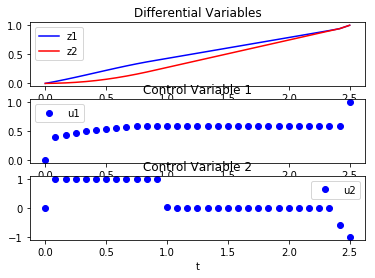

In [8]:
def plotter(subplot, x, *series, **kwds):
    plt.subplot(subplot)
    for i,y in enumerate(series):
        plt.plot(x, [value(y[t]) for t in x], 'brgcmk'[i%6]+kwds.get('points',''))
    plt.title(kwds.get('title',''))
    plt.legend(tuple(y.getname() for y in series))
    plt.xlabel(x.getname())

import matplotlib.pyplot as plt
plotter(311, m.t, m.z1, m.z2, title='Differential Variables')
plotter(312, m.t, m.u1, title='Control Variable 1', points='o')
plotter(313, m.t, m.u2, title='Control Variable 2', points='o')
plt.show()
